In [1]:
# General imports
import os
import sys
import pandas as pd
import scipy
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from tqdm import tqdm
sys.path.append('../')
# Other imports

tqdm.pandas()
import yaml
import json

# Figures imports
import matplotlib
from matplotlib.lines import Line2D   
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statannot import add_stat_annotation
import matplotlib.font_manager as font_manager
import string

from pandarallel import pandarallel

pandarallel.initialize(nb_workers=30, progress_bar=True)


## YAML FILES CONFIG
yaml = yaml.load(open("config/config_files.yaml"), Loader=yaml.FullLoader)
base_dir = yaml['base_directory']
sys.exit('EXIT : Need to specify the base_directory in config file : "conf_files.yaml"') if base_dir == 'TO_CHANGE' else None
    


# Font settings
font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

pvalues_cutoff = json.load(open('config/config_files.json'))['pvalues_cutoff']
pvalues_cutoff = [[e, str(e)] for e in pvalues_cutoff]

import matplotlib.font_manager as font_manager

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 18

INFO: Pandarallel will run on 30 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [19]:
genes = pd.read_parquet("/gstock/GeneIso/V2/Genes.parquet")
mrna = pd.read_parquet("/gstock/GeneIso/V2/mRNA.parquet")
exons = pd.read_parquet("/gstock/GeneIso/V2/Exons.parquet")
cds = pd.read_parquet("/gstock/GeneIso/V2/CDS.parquet")
five_UTR = pd.read_parquet("/gstock/GeneIso/V2/5_UTR.parquet")
three_UTR = pd.read_parquet("/gstock/GeneIso/V2/3_UTR.parquet")

introns = pd.read_parquet("/gstock/GeneIso/V2/Introns.parquet")
introns["Length"] = introns["Introns"].apply(lambda r: int(r.split("-")[1]) - int(r.split("-")[0]))


In [5]:
exons

,Miso_siso,GeneID,transcript_id,Strand,Chromosome/scaffold name,Exon region start (bp),Exon region end (bp),Exon_nb,Exon_length
0,Miso,ENSG00000000003,ENST00000373020,-1,X,100636608,100636806,1,198
1,Miso,ENSG00000000003,ENST00000373020,-1,X,100635558,100635746,2,188
2,Miso,ENSG00000000003,ENST00000373020,-1,X,100635178,100635252,3,74
3,Miso,ENSG00000000003,ENST00000373020,-1,X,100633931,100634029,4,98
4,Miso,ENSG00000000003,ENST00000373020,-1,X,100633405,100633539,5,134
...,...,...,...,...,...,...,...,...,...
536344,Siso,ENSG00000287542,ENST00000512194,1,4,88706752,88708450,26,1698
536345,Siso,ENSG00000288920,ENST00000484897,1,19,23763004,23763134,1,130
536346,Siso,ENSG00000288920,ENST00000484897,1,19,23807826,23807939,2,113
536347,Siso,ENSG00000288920,ENST00000484897,1,19,23808719,23808814,3,95


In [11]:
plt.rcParams.update({'font.size' : 18})

def custom_boxplot(data, x, y, hue, ax, ylim, title="Title",xlabel="",ylabel="", box_pairs=[()], palette=['grey'], id_string="A", padding_value_boxplot=1, padding_title=10, legend=False, x_legend=0):

    data = data.sort_values(by=hue,ascending=True)
    count = data.groupby([hue, x]).count()['GeneID'].reset_index().pivot(columns=[hue],values='GeneID',index=x).reset_index()
    count['Miso'] = count['Miso'].apply(lambda r: str(format(int(r), ',')))
    count['Siso'] = count['Siso'].apply(lambda r: str(format(int(r), ',')))
    count['Miso/Siso'] = count[x].astype(str) + '\n(' + count['Miso'] + ' / ' + count['Siso'] + ')'
    
    
    bw = 0.2
    cut = 0
    lw = 1.5

    box = sns.violinplot(data=data, x=x, y=y, hue=hue, showfliers=False, ax=ax, palette=palette, cut=cut, linewidth=lw, bw=bw, scale='width', alpha=0.3)

    plt.setp(box.collections, alpha=.3)

        
    ax.set_title(title, pad=padding_title)
    ax.set_ylim(ylim)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Length (bp)')
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_xticklabels(count['Miso/Siso'].values.tolist(), fontsize=14)
    
    if not x: 
        ax.spines['bottom'].set_linewidth(0)
        ax.axes.xaxis.set_visible(False)
        
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    
    if legend is True:
    
        handles, labels = ax.get_legend_handles_labels()

        ax.legend(handles= 
                  [ 
                    mpatches.Patch([0], [0], color=palette['Miso'], ),
                    mpatches.Patch([0], [0], color=palette['Siso'], ),
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='grey', markeredgecolor='black', markersize=15),
#                     matplotlib.lines.Line2D([0], [0], marker='s', color='w', label='Circle', markerfacecolor='grey', markeredgecolor='black', markersize=15)
                    ],  
              labels= ['MISOG', 'SISOG', "Median"], title='', ncol=3, bbox_to_anchor=(0.5,-1), loc='center right')
    else:
        ax.legend().remove()

    means = data.groupby([hue, x])[y].quantile(0.75).reset_index()
    medians = data.groupby([hue, x])[y].quantile(0.5).reset_index()
    for ms, x_shift in zip(['Miso', 'Siso'], [-0.2,0.2]):
        tmp_df_medians = medians.loc[medians['Miso_siso'] == ms]
        tmp_df_means = means.loc[means['Miso_siso'] == ms]
        x_plot = [e + x_shift for e in range(0,5)]
        if 'Introns' in title :
            ax.plot(x_plot, tmp_df_means[y].values, lw=2.5, color=palette[ms],  marker="s", markersize=8, markeredgecolor="black",  markeredgewidth=1, ls='-', )
            ax.plot(x_plot, tmp_df_medians[y].values, lw=2.5, color="white",  marker="o", markersize=6, markeredgecolor="black",  markeredgewidth=1, ls='', )
        else:
            ax.plot(x_plot, tmp_df_medians[y].values, lw=2.5, color=palette[ms],  marker="o", markersize=10, markeredgecolor="black",  markeredgewidth=1, ls='-', )

    add_stat_annotation(ax, data=data, x=x, y=y, hue=hue, box_pairs=box_pairs,
                        test='Mann-Whitney', text_format='simple',  pvalue_thresholds=pvalues_cutoff,
                        loc='outside', fontsize=9, verbose=2, line_height=0.0025, line_offset=0.012)

    return ax

In [18]:
introns

,Miso_siso,GeneID,transcript_id,Strand,Chromosome/scaffold name,Introns,Introns_nb
0,Miso,ENSG00000000003,ENST00000373020,-1,X,100635747-100636607,1.0
1,Miso,ENSG00000000003,ENST00000373020,-1,X,100635253-100635557,2.0
2,Miso,ENSG00000000003,ENST00000373020,-1,X,100634030-100635177,3.0
3,Miso,ENSG00000000003,ENST00000373020,-1,X,100633540-100633930,4.0
4,Miso,ENSG00000000003,ENST00000373020,-1,X,100632569-100633404,5.0
...,...,...,...,...,...,...,...
488800,Siso,ENSG00000287542,ENST00000512194,1,4,88704282-88704507,24.0
488801,Siso,ENSG00000287542,ENST00000512194,1,4,88704611-88706751,25.0
488802,Siso,ENSG00000288920,ENST00000484897,1,19,23763135-23807825,1.0
488803,Siso,ENSG00000288920,ENST00000484897,1,19,23807940-23808718,2.0


In [33]:
five_UTR_new = pd.merge(five_UTR, genes[['GeneID', 'transcript_count']], on='GeneID')
five_UTR_new = five_UTR_new.loc[(five_UTR_new['transcript_count'] <= 10) & (five_UTR_new['5_UTR_nb'] <= 5)]
five_UTR_new

,GeneID,transcript_id,Strand,Chromosome/scaffold name,Exon region start (bp),Exon region end (bp),5' UTR start,5' UTR end,3' UTR start,3' UTR end,CDS start,CDS end,Miso_siso,5_UTR_nb,5_UTR_length,transcript_count
0,ENSG00000000003,ENST00000373020,-1,X,100636608,100636806,100636695.0,100636806.0,NaN,NaN,1.0,87.0,Miso,1.0,111.0,3
1,ENSG00000000003,ENST00000612152,-1,X,100636793,100637104,100636793.0,100637104.0,NaN,NaN,NaN,NaN,Miso,1.0,311.0,3
2,ENSG00000000003,ENST00000612152,-1,X,100635558,100635746,100635570.0,100635746.0,NaN,NaN,1.0,12.0,Miso,2.0,176.0,3
3,ENSG00000000003,ENST00000614008,-1,X,100636793,100637104,100636793.0,100637104.0,NaN,NaN,NaN,NaN,Miso,1.0,311.0,3
4,ENSG00000000003,ENST00000614008,-1,X,100635558,100635746,100635570.0,100635746.0,NaN,NaN,1.0,12.0,Miso,2.0,176.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82355,ENSG00000287542,ENST00000512194,1,4,88605795,88606049,88605795.0,88605823.0,NaN,NaN,1.0,226.0,Siso,4.0,28.0,1
82356,ENSG00000288920,ENST00000484897,1,19,23763004,23763134,23763004.0,23763134.0,NaN,NaN,NaN,NaN,Siso,1.0,130.0,1
82357,ENSG00000288920,ENST00000484897,1,19,23807826,23807939,23807826.0,23807939.0,NaN,NaN,NaN,NaN,Siso,2.0,113.0,1
82358,ENSG00000288920,ENST00000484897,1,19,23808719,23808814,23808719.0,23808814.0,NaN,NaN,NaN,NaN,Siso,3.0,95.0,1


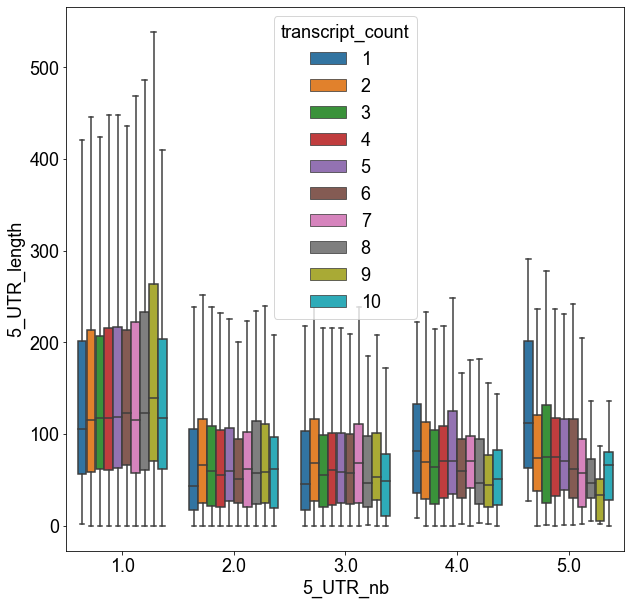

In [37]:
plt.figure(figsize=(10,10))
sns.boxplot(data=five_UTR_new.sort_values(by='transcript_count'), x='5_UTR_nb', y='5_UTR_length', hue="transcript_count", showfliers=False)

In [80]:
exons

,Miso_siso,GeneID,transcript_id,Strand,Chromosome/scaffold name,Exon region start (bp),Exon region end (bp),Exon_nb,Exon_length
0,Miso,ENSG00000000003,ENST00000373020,-1,X,100636608,100636806,1,198
1,Miso,ENSG00000000003,ENST00000373020,-1,X,100635558,100635746,2,188
2,Miso,ENSG00000000003,ENST00000373020,-1,X,100635178,100635252,3,74
3,Miso,ENSG00000000003,ENST00000373020,-1,X,100633931,100634029,4,98
4,Miso,ENSG00000000003,ENST00000373020,-1,X,100633405,100633539,5,134
...,...,...,...,...,...,...,...,...,...
536344,Siso,ENSG00000287542,ENST00000512194,1,4,88706752,88708450,26,1698
536345,Siso,ENSG00000288920,ENST00000484897,1,19,23763004,23763134,1,130
536346,Siso,ENSG00000288920,ENST00000484897,1,19,23807826,23807939,2,113
536347,Siso,ENSG00000288920,ENST00000484897,1,19,23808719,23808814,3,95


transcript_count
1    0.275132
2    0.331822
3    0.195692
4    0.107407
5    0.051247
6    0.025850
7    0.012850
Name: GeneID, dtype: float64

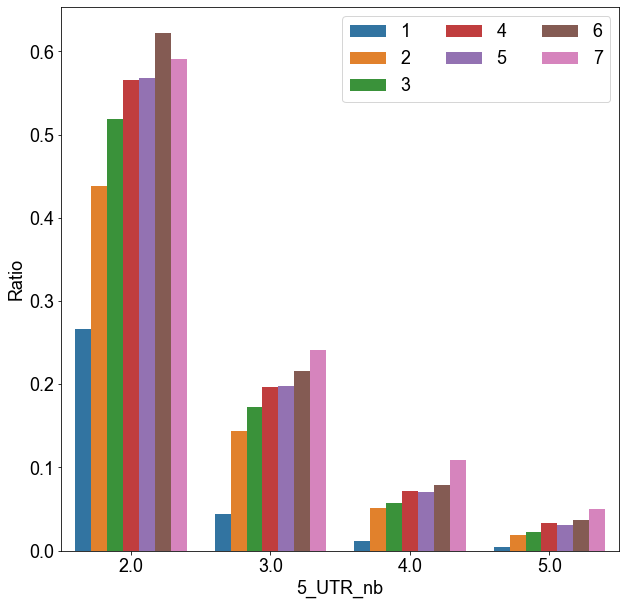

In [77]:
five_UTR_new = pd.merge(five_UTR, genes[['GeneID', 'transcript_count']], on='GeneID')
five_UTR_new = five_UTR_new.loc[(five_UTR_new['5_UTR_nb'] <= 5)]
five_UTR_new = five_UTR_new.loc[(five_UTR_new['transcript_count'] <= 7)] 
five_UTR_new

tmp = five_UTR_new.groupby(['transcript_count', '5_UTR_nb'])['GeneID'].count() / five_UTR_new.groupby(['transcript_count'])['transcript_id'].nunique()
# tmp = five_UTR_new.groupby(['transcript_count', '5_UTR_nb'])['GeneID'].count() 
tmp = tmp.rename('Ratio').reset_index()
tmp
# five_UTR_new.groupby(['transcript_count', '5_UTR_nb'])['GeneID'].count()
# five_UTR_new.groupby(['transcript_count'])['transcript_id'].nunique()
plt.figure(figsize=(10,10))
sns.barplot(data=tmp.loc[tmp['5_UTR_nb'] > 1], x='5_UTR_nb', y='Ratio', hue="transcript_count")
plt.legend(ncol=3)
five_UTR_new.groupby(['transcript_count'])['GeneID'].nunique() / five_UTR_new.groupby(['transcript_count'])['GeneID'].nunique().sum()

transcript_count
1    0.275761
2    0.331547
3    0.195591
4    0.107270
5    0.051181
6    0.025817
7    0.012833
Name: GeneID, dtype: float64

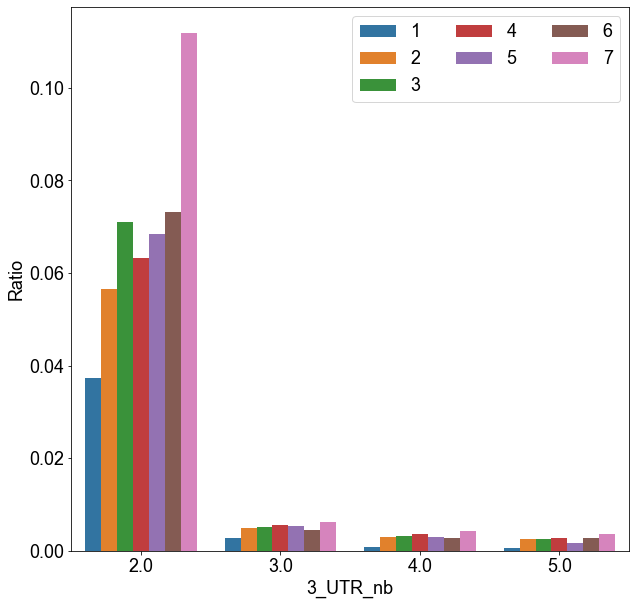

In [79]:
three_UTR_new = pd.merge(three_UTR, genes[['GeneID', 'transcript_count']], on='GeneID')
three_UTR_new = three_UTR_new.loc[(three_UTR_new['3_UTR_nb'] <= 5)]
three_UTR_new = three_UTR_new.loc[(three_UTR_new['transcript_count'] <= 7)] 
three_UTR_new

tmp = three_UTR_new.groupby(['transcript_count', '3_UTR_nb'])['GeneID'].count() / three_UTR_new.groupby(['transcript_count'])['transcript_id'].nunique()
# tmp = five_UTR_new.groupby(['transcript_count', '5_UTR_nb'])['GeneID'].count() 
tmp = tmp.rename('Ratio').reset_index()
tmp
# five_UTR_new.groupby(['transcript_count', '5_UTR_nb'])['GeneID'].count()
# five_UTR_new.groupby(['transcript_count'])['transcript_id'].nunique()
plt.figure(figsize=(10,10))
sns.barplot(data=tmp.loc[tmp['3_UTR_nb'] > 1], x='3_UTR_nb', y='Ratio', hue="transcript_count")
plt.legend(ncol=3)
three_UTR_new.groupby(['transcript_count'])['GeneID'].nunique() / three_UTR_new.groupby(['transcript_count'])['GeneID'].nunique().sum()

transcript_count
1    0.275132
2    0.331822
3    0.195692
4    0.107407
5    0.051247
6    0.025850
7    0.012850
Name: GeneID, dtype: float64

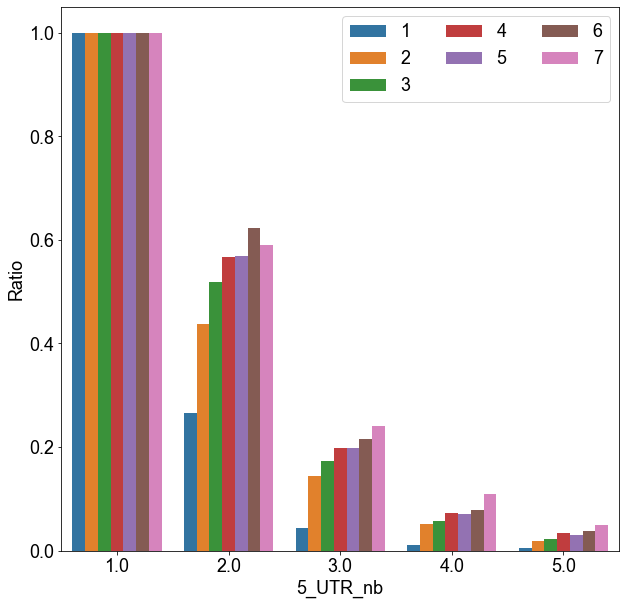

In [81]:
five_UTR_new = pd.merge(five_UTR, genes[['GeneID', 'transcript_count']], on='GeneID')
five_UTR_new = five_UTR_new.loc[(five_UTR_new['5_UTR_nb'] <= 5)]
five_UTR_new = five_UTR_new.loc[(five_UTR_new['transcript_count'] <= 7)] 
five_UTR_new

tmp = five_UTR_new.groupby(['transcript_count', '5_UTR_nb'])['GeneID'].count() / five_UTR_new.groupby(['transcript_count'])['transcript_id'].nunique()
# tmp = five_UTR_new.groupby(['transcript_count', '5_UTR_nb'])['GeneID'].count() 
tmp = tmp.rename('Ratio').reset_index()
tmp
# five_UTR_new.groupby(['transcript_count', '5_UTR_nb'])['GeneID'].count()
# five_UTR_new.groupby(['transcript_count'])['transcript_id'].nunique()
plt.figure(figsize=(10,10))
sns.barplot(data=tmp.loc[tmp['5_UTR_nb'] >= 1], x='5_UTR_nb', y='Ratio', hue="transcript_count")
plt.legend(ncol=3)
five_UTR_new.groupby(['transcript_count'])['GeneID'].nunique() / five_UTR_new.groupby(['transcript_count'])['GeneID'].nunique().sum()

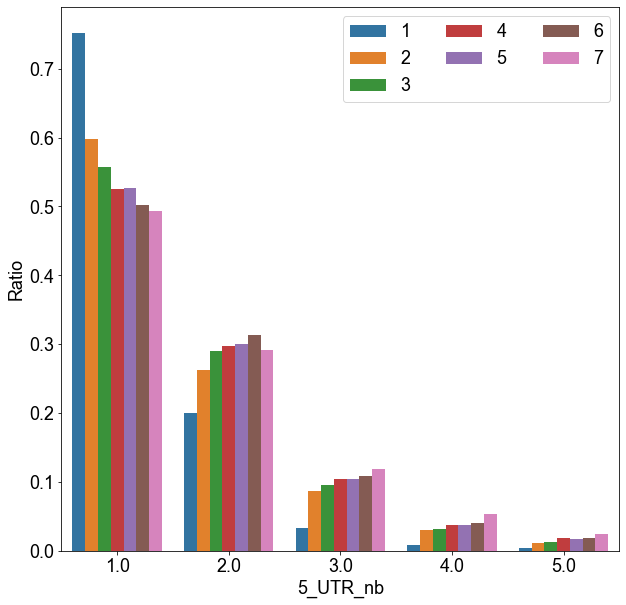

In [93]:
five_UTR_new = pd.merge(five_UTR, genes[['GeneID', 'transcript_count']], on='GeneID')
# five_UTR_new = five_UTR_new.loc[(five_UTR_new['5_UTR_nb'] <= 5)]
five_UTR_new = five_UTR_new.loc[(five_UTR_new['transcript_count'] <= 7)] 
five_UTR_new

tmp = five_UTR_new.groupby(['transcript_count', '5_UTR_nb'])['GeneID'].count() 
# # tmp = five_UTR_new.groupby(['transcript_count', '5_UTR_nb'])['GeneID'].count() 
tmp = tmp / tmp.groupby('transcript_count').sum()
tmp = tmp.rename('Ratio').reset_index()
tmp
# # five_UTR_new.groupby(['transcript_count', '5_UTR_nb'])['GeneID'].count()
# # five_UTR_new.groupby(['transcript_count'])['transcript_id'].nunique()
plt.figure(figsize=(10,10))
sns.barplot(data=tmp.loc[(tmp['5_UTR_nb'] <= 5) & (tmp['transcript_count'] <= 7)], x='5_UTR_nb', y='Ratio', hue="transcript_count")
plt.legend(ncol=3)
# five_UTR_new.groupby(['transcript_count'])['GeneID'].nunique() / five_UTR_new.groupby(['transcript_count'])['GeneID'].nunique().sum()

[((1, 'Miso'), (1, 'Siso')), ((2, 'Miso'), (2, 'Siso')), ((3, 'Miso'), (3, 'Siso')), ((4, 'Miso'), (4, 'Siso')), ((5, 'Miso'), (5, 'Siso')), ((1, 'Miso'), (2, 'Miso')), ((1, 'Miso'), (3, 'Miso')), ((1, 'Miso'), (4, 'Miso')), ((1, 'Miso'), (5, 'Miso')), ((1, 'Siso'), (2, 'Siso')), ((1, 'Siso'), (3, 'Siso')), ((1, 'Siso'), (4, 'Siso')), ((1, 'Siso'), (5, 'Siso'))]
2_Miso v.s. 2_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.706e-64 U_stat=6.668e+07
1_Miso v.s. 1_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.990e-66 U_stat=6.673e+07
3_Miso v.s. 3_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.410e-22 U_stat=6.060e+07
4_Miso v.s. 4_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.826e-13 U_stat=5.113e+07
5_Miso v.s. 5_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.098e-04 U_stat=4.253e+07
1_Miso v.s. 2_Miso: Mann-Whitney-Wilcoxon tes

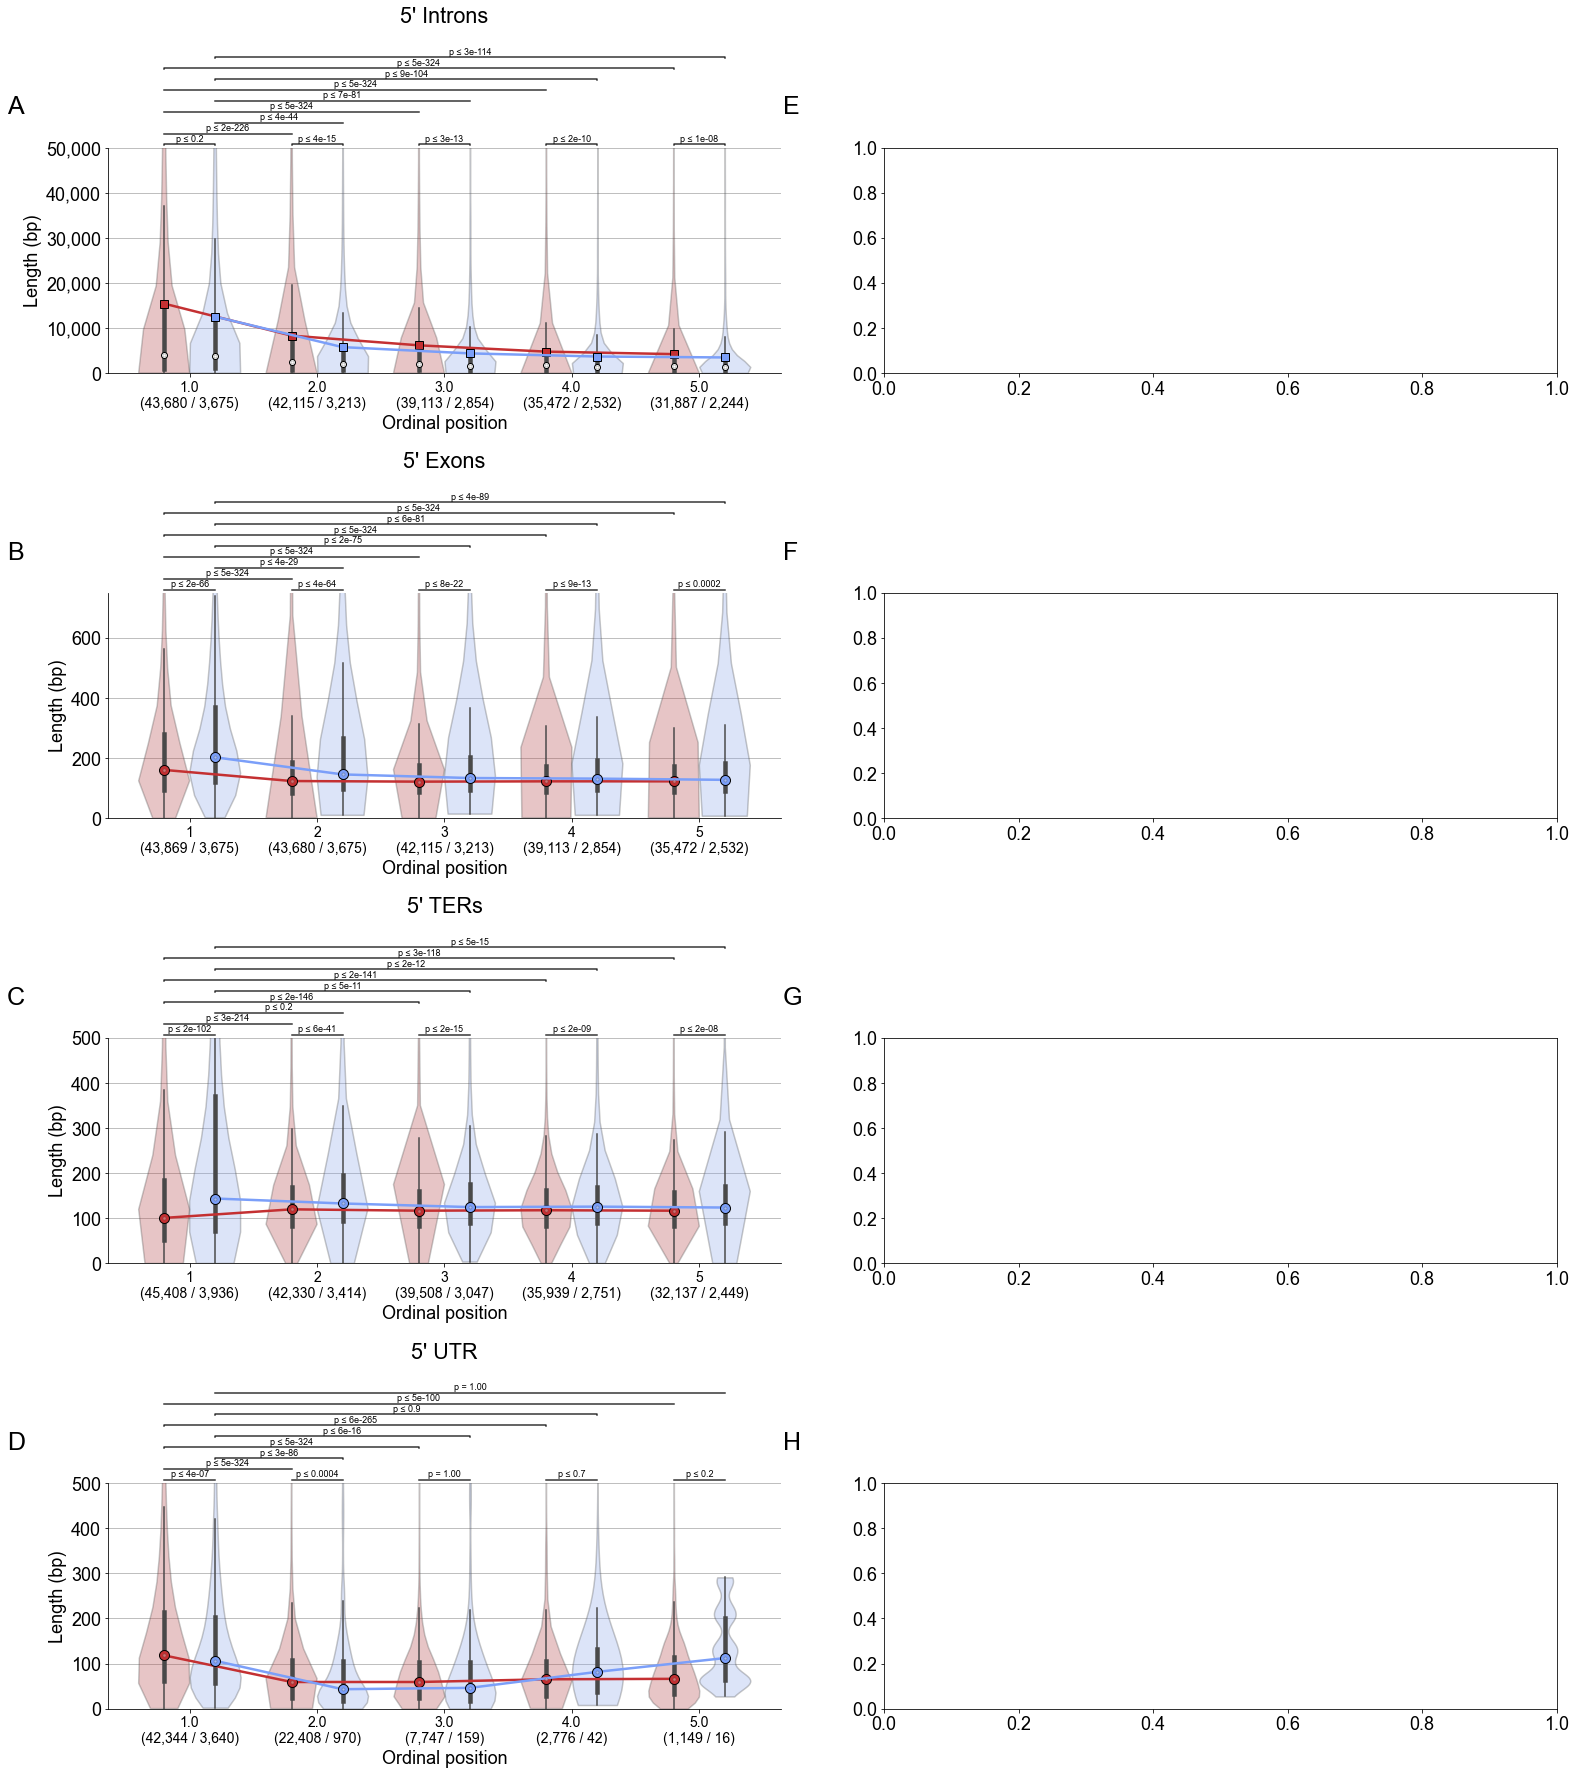

In [21]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(22,25))

custom_boxplot(data=exons.loc[(exons['Exon_nb'] <= 5)], x='Exon_nb', y='Exon_length', hue='Miso_siso', ax=ax[1][0], ylim=(0,750), xlabel='Ordinal position', palette=palette, title="5' Exons", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=cds.loc[(cds['CDS_nb'] <= 5)], x='CDS_nb', y='CDS_length', hue='Miso_siso', xlabel='Ordinal position', ax=ax[2][0], ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' TERs", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=introns.loc[(introns['Introns_nb'] <= 5)], x='Introns_nb', y='Length', hue='Miso_siso', ax=ax[0][0], xlabel='Ordinal position', ylim=(0,5e4), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' Introns", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=five_UTR.loc[(five_UTR['5_UTR_nb'] <= 5)], x='5_UTR_nb', y='5_UTR_length', hue='Miso_siso', ax=ax[3][0], xlabel='Ordinal position', ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' UTR", box_pairs=box_pairs, padding_title=padding_title)


[((1, 'Miso'), (1, 'Siso')), ((2, 'Miso'), (2, 'Siso')), ((3, 'Miso'), (3, 'Siso')), ((4, 'Miso'), (4, 'Siso')), ((5, 'Miso'), (5, 'Siso')), ((1, 'Miso'), (2, 'Miso')), ((1, 'Miso'), (3, 'Miso')), ((1, 'Miso'), (4, 'Miso')), ((1, 'Miso'), (5, 'Miso')), ((1, 'Siso'), (2, 'Siso')), ((1, 'Siso'), (3, 'Siso')), ((1, 'Siso'), (4, 'Siso')), ((1, 'Siso'), (5, 'Siso'))]
2_Miso v.s. 2_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.706e-64 U_stat=6.668e+07
1_Miso v.s. 1_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.990e-66 U_stat=6.673e+07
3_Miso v.s. 3_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.410e-22 U_stat=6.060e+07
4_Miso v.s. 4_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.826e-13 U_stat=5.113e+07
5_Miso v.s. 5_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.098e-04 U_stat=4.253e+07
1_Miso v.s. 2_Miso: Mann-Whitney-Wilcoxon tes

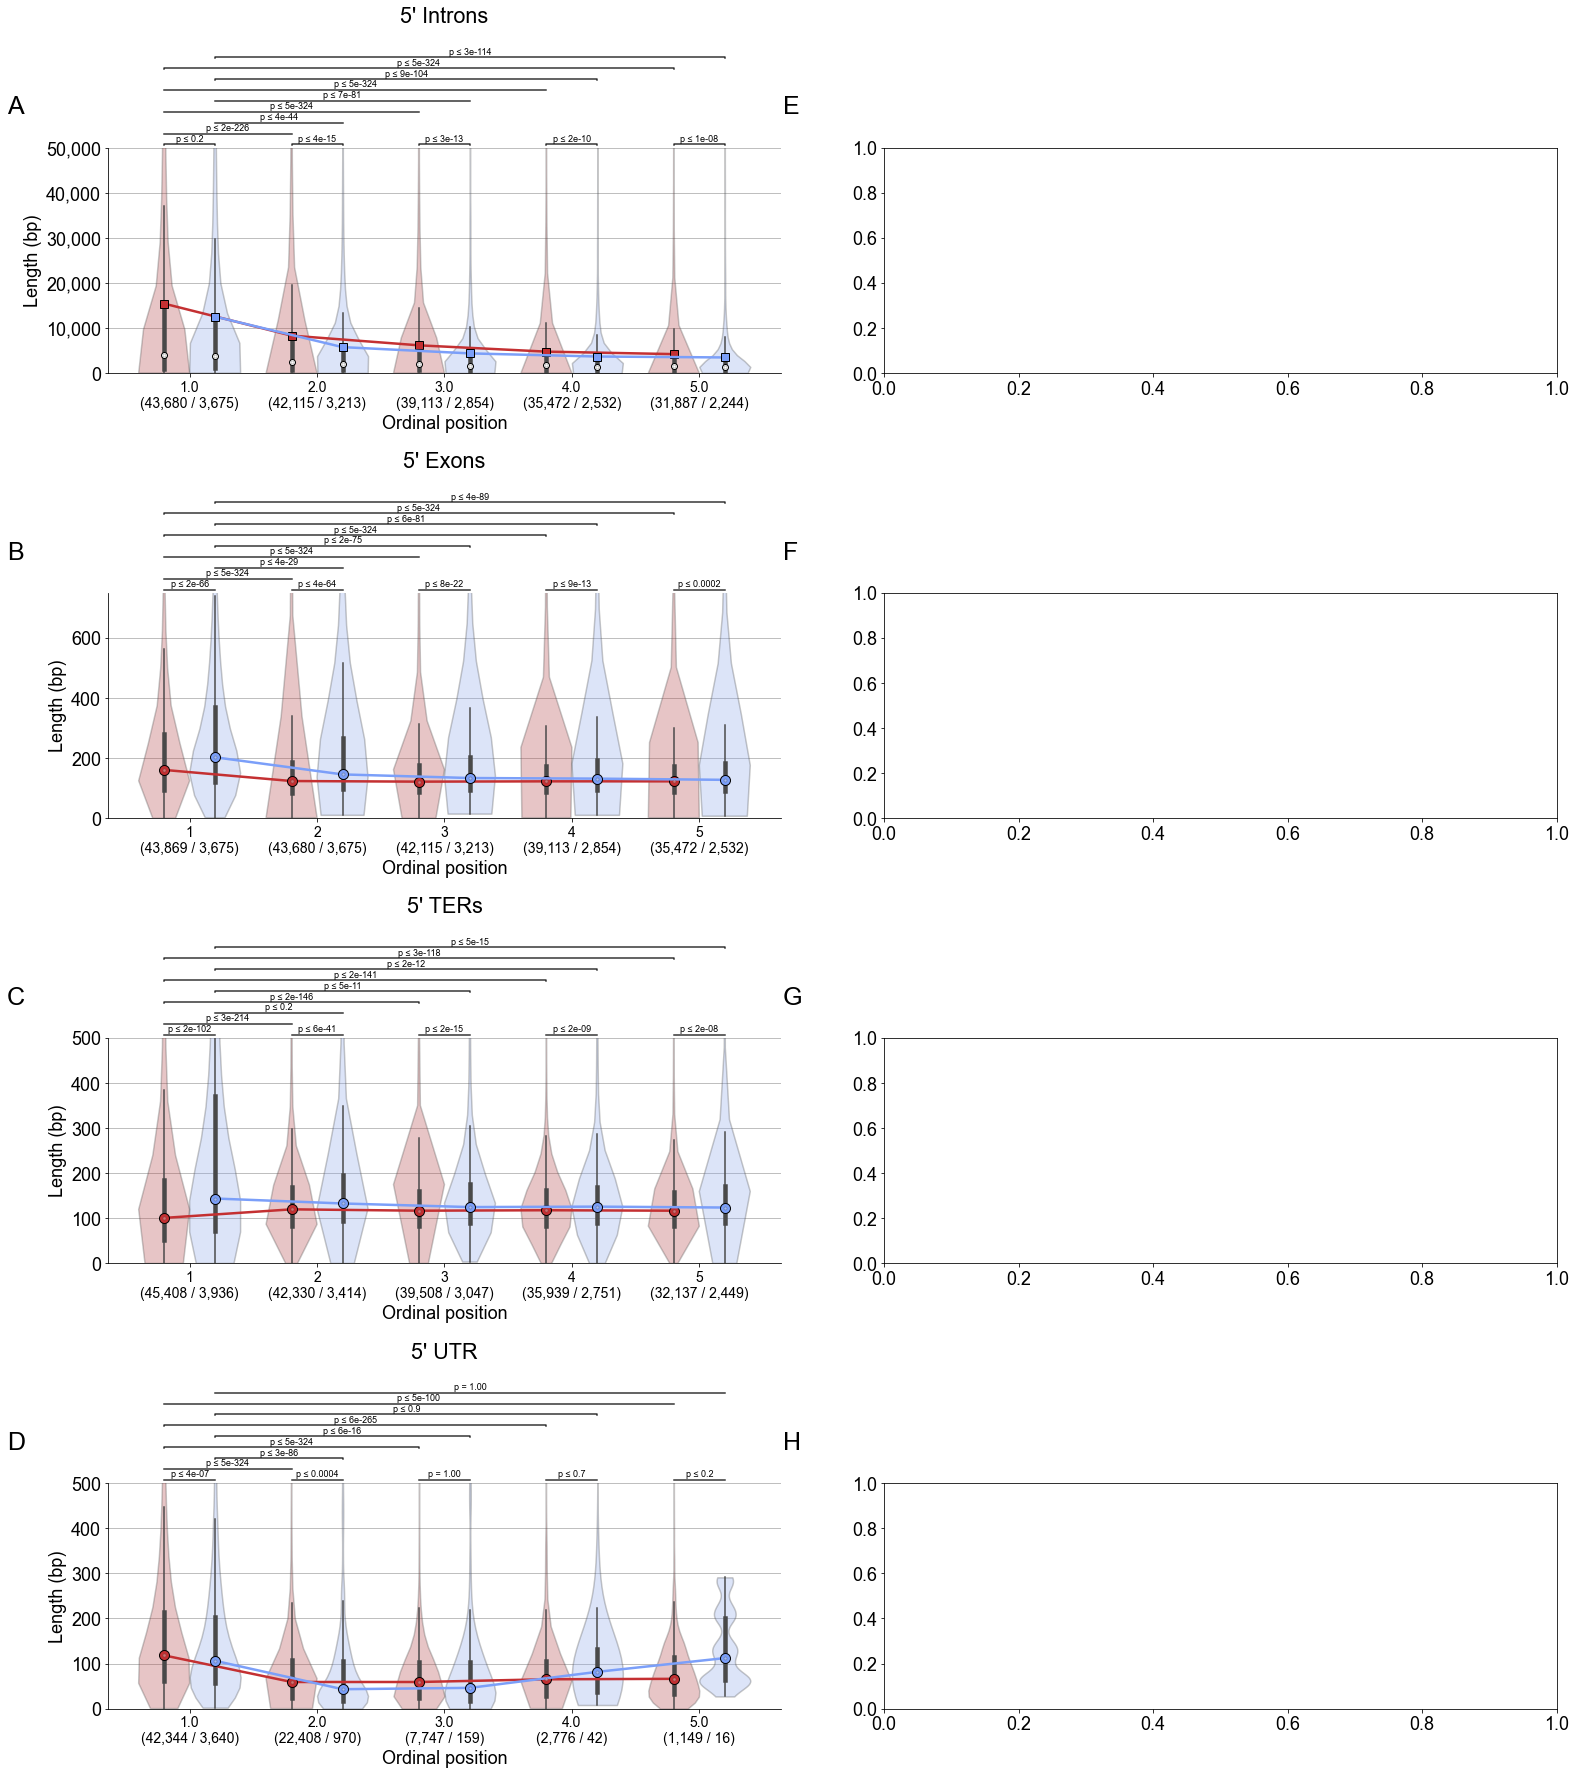

In [21]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(22,25))
palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
box_pairs = [
    ((e,'Miso'),(e,'Siso')) for e in range(1,6)
]

box_pairs = box_pairs + [((1,'Miso'),(e,'Miso')) for e in range(2,6)] + [((1,'Siso'),(e,'Siso')) for e in range(2,6)]

print(box_pairs)

k_limit = 5
zscore_cutoff = 2
padding_title = 125


custom_boxplot(data=exons.loc[(exons['Exon_nb'] <= 5)], x='Exon_nb', y='Exon_length', hue='Miso_siso', ax=ax[1][0], ylim=(0,750), xlabel='Ordinal position', palette=palette, title="5' Exons", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=cds.loc[(cds['CDS_nb'] <= 5)], x='CDS_nb', y='CDS_length', hue='Miso_siso', xlabel='Ordinal position', ax=ax[2][0], ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' TERs", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=introns.loc[(introns['Introns_nb'] <= 5)], x='Introns_nb', y='Length', hue='Miso_siso', ax=ax[0][0], xlabel='Ordinal position', ylim=(0,5e4), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' Introns", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=five_UTR.loc[(five_UTR['5_UTR_nb'] <= 5)], x='5_UTR_nb', y='5_UTR_length', hue='Miso_siso', ax=ax[3][0], xlabel='Ordinal position', ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' UTR", box_pairs=box_pairs, padding_title=padding_title)


box_pairs = [
    ((e,'Miso'),(e,'Siso')) for e in list(range(-5,0))
]
box_pairs = box_pairs + [((-1,'Miso'),(e,'Miso')) for e in range(-5,-1)] + [((-1,'Siso'),(e,'Siso')) for e in range(-5,-1)]

# custom_boxplot(data=concat_cds_exons.loc[(concat_cds_exons['Type'] == 'exon')  & (concat_cds_exons['Nb_exon_inverted'] >= -5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon_inverted', 'Length']].drop_duplicates(), x='Nb_exon_inverted', y='Length', hue='Miso_siso',xlabel='Ordinal position', ax=ax[1][1], ylim=(0,6.5e3), palette=palette, title="3' Exons", box_pairs=box_pairs, padding_title=padding_title)
# custom_boxplot(data=concat_cds_exons.loc[(concat_cds_exons['Type'] == 'CDS') & (concat_cds_exons['Nb_exon_inverted'] >= -5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon_inverted', 'Length']].drop_duplicates(), x='Nb_exon_inverted', y='Length', hue='Miso_siso', xlabel='Ordinal position',ax=ax[2][1], ylim=(0,500), palette=palette, title="3' TERs", box_pairs=box_pairs, padding_title=padding_title)
# custom_boxplot(data=concat_introns.loc[(concat_introns['Type'] == 'exon') & (concat_introns['Nb_exon_inverted'] >= -5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon_inverted', 'Intron_Length']].drop_duplicates(), x='Nb_exon_inverted', y='Intron_Length', hue='Miso_siso',xlabel='Ordinal position', ax=ax[0][1], ylim=(0,50e3), palette=palette, title="3' Introns", box_pairs=box_pairs, padding_title=padding_title, )
# custom_boxplot(data=utrs.loc[(utrs['UTR_bool'] == '3_prime') & (utrs['Nb_exon_inverted'] >= -5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon_inverted', 'UTR_Length']].drop_duplicates(), x='Nb_exon_inverted', y='UTR_Length', hue='Miso_siso',  xlabel='Ordinal position',ax=ax[3][1], ylim=(0,6e3), palette=palette, title="3' UTR", box_pairs=box_pairs, padding_title=padding_title, legend=True, x_legend=1.35,)


i = 0
for n, a in enumerate(ax):
    print(a)
    sub_a = a[0]
    sub_a.text(-0.15, 1.15, string.ascii_uppercase[i], transform=sub_a.transAxes, size=25, weight='bold')
    i += 1
for n, a in enumerate(ax):
    sub_a = a[1]
    sub_a.text(-0.15, 1.15, string.ascii_uppercase[i], transform=sub_a.transAxes, size=25, weight='bold')
    i += 1

plt.tight_layout()

# figure_path = base_dir + yaml['Figures']['FigS1']
# f.savefig(figure_path, dpi=600)